# Part 1 - Feature Extraction and Classifier Training

Helper methods to extract features from images. HOG, color histogram and spatial bins.

In [2]:
# helper functions. Taken over from the intro tutorials
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(image)      


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion
        feature_image = convert_color(image, color_space)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Read in training data

In [3]:
import glob
# Read in cars and notcars from project dataset
#Fortunately glob returns a list of files... 
cars =glob.glob('project_dataset/vehicles/**/*.png')
notcars =glob.glob('project_dataset/non-vehicles/**/*.png')

Extract features from training data

In [4]:
from sklearn.preprocessing import StandardScaler

### Feauture parameters ###
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
###########################

print("Begin extraction of features from CAR labeled data")

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("done.")
print("Begin extraction of features from NOTCAR labeled data")
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("done.")
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

Begin extraction of features from CAR labeled data
done.
Begin extraction of features from NOTCAR labeled data
done.


Training of model

In [5]:
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
32.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


# Part 2 - Illustration of pipeline steps

Training data contents

Amount of cars in training data
8792
Amount of other objects (not cars) in training data
8968


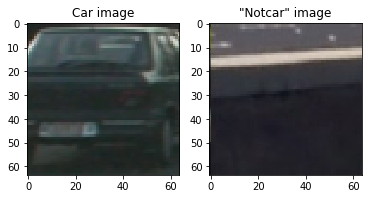

In [6]:
import matplotlib.pyplot as plt
print("Amount of cars in training data")
print(len(cars))

print("Amount of other objects (not cars) in training data")
print(len(notcars))

rand_index = np.random.randint(0, len(cars))
car_img = mpimg.imread(cars[rand_index])
nocar_img = mpimg.imread(notcars[rand_index])

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car image')
plt.subplot(122)
plt.imshow(nocar_img)
plt.title('"Notcar" image')
fig.tight_layout
plt.show()

Illustration of extracted features and colourspace used 

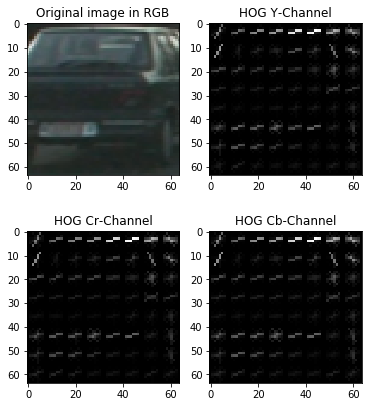

In [7]:
#extract hog features from example image

hog_features_ch0, hog_image_ch0 = get_hog_features(car_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog_features_ch1, hog_image_ch1 = get_hog_features(car_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog_features_ch2, hog_image_ch2 = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

car_img_original = car_img
car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)


fig = plt.figure(figsize=(6,7))
plt.subplot(221)
plt.imshow(car_img_original)
plt.title('Original image in RGB')
plt.subplot(222)
plt.imshow(hog_image_ch0, cmap="gray")
plt.title('HOG Y-Channel')
plt.subplot(223)
plt.imshow(hog_image_ch1, cmap="gray")
plt.title('HOG Cr-Channel')
plt.subplot(224)
plt.imshow(hog_image_ch2, cmap="gray")
plt.title('HOG Cb-Channel')
fig.tight_layout
plt.show()

Search grid demo

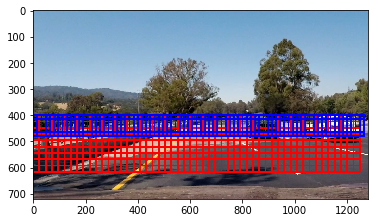

In [31]:
import matplotlib.image as mpimg
from skimage.feature import hog
import matplotlib.pyplot as plt

########### Illustration of search grid #############
def show_search_grid(img, ystart, ystop, scale, pix_per_cell, cell_per_block):
    
    boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes

def just_draw(img, boxes, color=(0,0,255)):
    boxedImage = np.copy(img)
    for box in boxes:
        cv2.rectangle(boxedImage, box[0], box[1], color, 6)
    return boxedImage

image = mpimg.imread('images/test_images/test4.jpg')

ystart = 400
ystop = 656
scale = 1.5
redboxes = show_search_grid(image, ystart, ystop, scale, pix_per_cell, cell_per_block)
ystart = 400
ystop = 500
scale = 1.0
blueboxes = show_search_grid(image, ystart, ystop, scale, pix_per_cell, cell_per_block)
image_red_boxes = just_draw(image, redboxes, color=(255,0,0))
image_blue_boxes = just_draw(image_red_boxes, blueboxes, color=(0,0,255))
plt.imshow(image_blue_boxes)
plt.show()

Classification demo

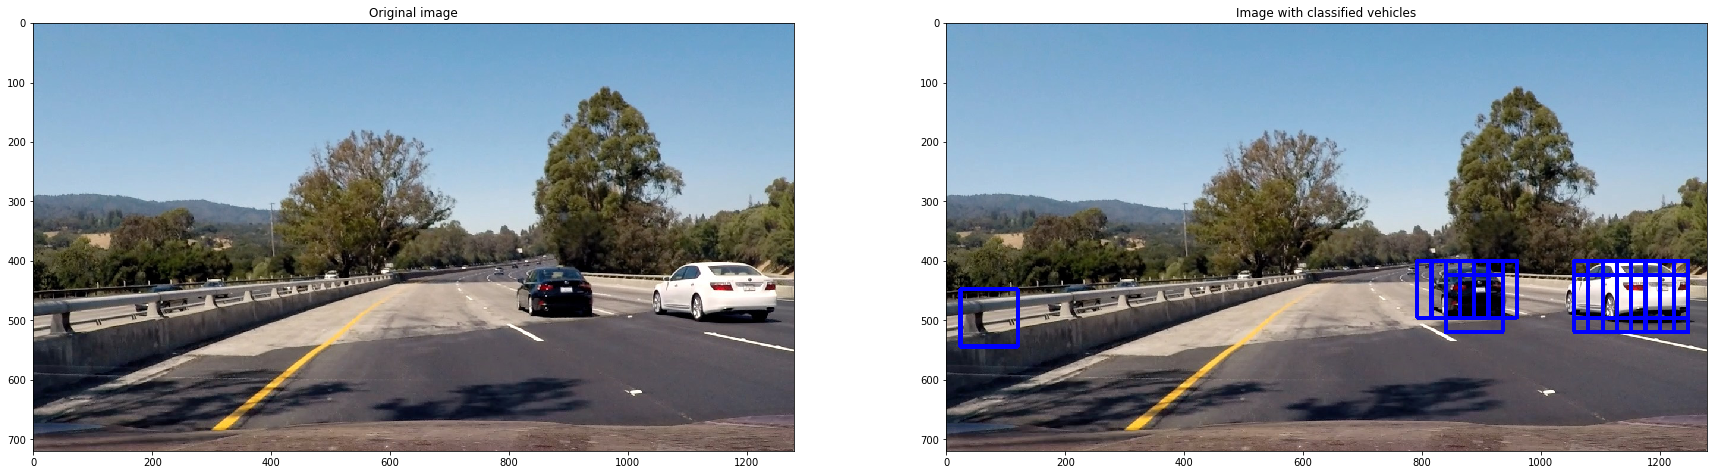

In [27]:
# This is used only for illustration of a simple classification example. Method is not called within the pipeline.
def find_cars_demo(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)        
    return draw_img

#define search space and box size
ystart = 400
ystop = 656
scale = 1.5
#read image
image = mpimg.imread('images/test_images/test4.jpg')
#perform example classification
img_demo = find_cars_demo(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)

#display results
fig = plt.figure(figsize=(30,60))
plt.subplot(121)
plt.imshow(image)
plt.title('Original image')
plt.subplot(122)
plt.imshow(img_demo)
plt.title('Image with classified vehicles')
plt.show()


Heat map demo

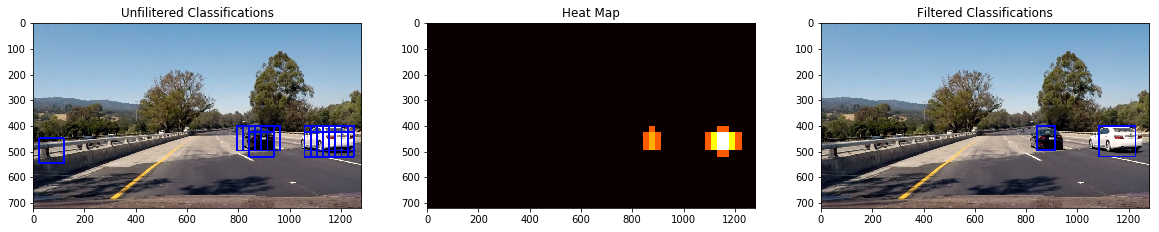

In [28]:
from scipy.ndimage.measurements import label

from skimage.feature import hog
import matplotlib.pyplot as plt


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_heatmap_demo(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
        
    boxes = []

    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #store found boxes
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes
    
                
### Ident. of false positives and multiple classifications ###
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


image = mpimg.imread('images/test4.jpg')
ystart = 400
ystop = 656
scale = 1.5
#start search
boxes=find_cars_heatmap_demo(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)

no_heatmap = just_draw(np.copy(image), boxes)

fig = plt.figure(figsize=(20,30))
plt.subplot(131)
plt.imshow(no_heatmap)
plt.title('Unfilitered Classifications')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Filtered Classifications')
fig.tight_layout
plt.show()

# Part 3 - Classification Pipeline

Sliding window and heat map implementation

In [36]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
        
    boxes = []

    img = img.astype(np.float32)/255
    #img = cv2.GaussianBlur(img, (3, 3), 0)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #store found boxes
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes
    
                
### Ident. of false positives and multiple classifications ###
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_vehicles(img, carlist):
    # Iterate through all detected cars
    for car in carlist:
        if(car.detected == False):
            car.detections = car.detections -1 ;
            car.nodetections = car.nodetections + 1
        if(car.detections > 5):
            xstart = car.xstart
            xend = car.xend
            ystart = car.ystart
            yend = car.yend
            bbox = ((int(xstart), int(ystart)), (int(xend), int(yend)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        if(car.nodetections > 30):
            #remove car from list 
            carlist.remove(car)
    # Return the image
    return img


Video pipeline

In [ ]:
class CarList():
    def __init__(self):
        self.list = []
    
class Car():
    id = 0
    def __init__(self):
        self.id = Car.id
        Car.id =+ 1
        self.detected = False
        self.detections = 0
        self.nodetections = 0
        self.xcenter = None
        self.ycenter = None
        self.xstart = None
        self.xend  = None
        self.ystart = None
        self.yend  = None
        self.xposstarthistory = []
        self.xposendhistory = []        
        self.yposstarthistory = []
        self.yposendhistory = []

        
def track_vehicles_from_labels(labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):  
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        xcenter = (np.min(nonzerox) + np.max(nonzerox)) / 2
        ycenter = (np.min(nonzeroy) + np.max(nonzeroy)) / 2

        hit = False
        if(myList.list):
            for i in myList.list:
                i.detected = False
            for i in myList.list:
                xdelta = i.xcenter-xcenter
                ydelta = i.ycenter - ycenter
                if((abs(xdelta)<150) and (abs(ydelta)<150)):
                    hit = True
                    #existing object
                    i.detected = True
                    i.detections = i.detections+1
                    if(i.detections > 30):
                        #remove the oldest entry
                        i.xposstarthistory.pop(0)
                        i.xposendhistory.pop(0)
                        i.yposstarthistory.pop(0)
                        i.yposendhistory.pop(0)
                    i.nodetections = 0
                    i.xposstarthistory.append(np.min(nonzerox))
                    i.xposendhistory.append(np.max(nonzerox))
                    i.yposstarthistory.append(np.min(nonzeroy))
                    i.yposendhistory.append(np.max(nonzeroy))
                    i.xstart = np.mean(i.xposstarthistory)
                    i.xend  = np.mean(i.xposendhistory)
                    i.ystart = np.mean(i.yposstarthistory)
                    i.yend  = np.mean(i.yposendhistory)
                    i.xcenter = (i.xstart + i.xend) / 2
                    i.ycenter = (i.ystart + i.yend) / 2
        else:
            #fist object
            hit = True
            a = Car()
            a.detected = True
            a.detections = 1
            a.xcenter = xcenter
            a.ycenter = ycenter
            a.xstart = np.min(nonzerox)
            a.xend  = np.max(nonzerox)
            a.ystart = np.min(nonzeroy)
            a.yend  = np.max(nonzeroy)
            a.xposstarthistory.append(np.min(nonzerox))
            a.xposendhistory.append(np.max(nonzerox))
            a.yposstarthistory.append(np.min(nonzeroy))
            a.yposendhistory.append(np.max(nonzeroy))
            myList.list.append(a)
        
        if(hit == False):
            #new object
            a = Car()
            a.detected = True
            a.detections = 1
            a.xcenter = xcenter
            a.ycenter = ycenter
            a.xstart = np.min(nonzerox)
            a.xend  = np.max(nonzerox)
            a.ystart = np.min(nonzeroy)
            a.yend  = np.max(nonzeroy)
            a.xposstarthistory.append(np.min(nonzerox))
            a.xposendhistory.append(np.max(nonzerox))
            a.yposstarthistory.append(np.min(nonzeroy))
            a.yposendhistory.append(np.max(nonzeroy))
            myList.list.append(a)
        
from scipy.ndimage.measurements import label
def processImage(image):
    ystart = 400
    ystop = 656
    scale = 1.5
    boxes1=find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 400
    ystop = 500
    scale = 1.0
    boxes2=find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    
    boxes = []
    for i in boxes1:
        boxes.append(i)
    for i in boxes2:
        boxes.append(i)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    #heat = add_heat(heat,my_memory.boxes)
    heat = add_heat(heat,boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    track_vehicles_from_labels(labels)    
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_vehicles(np.copy(image), myList.list)

    return draw_img


from moviepy.editor import VideoFileClip
from IPython.display import HTML
if __name__ == '__main__':
    outputFile = 'project_video_processed.mp4'    
    originalClip = VideoFileClip('project_video.mp4')#.subclip(35,40)
    myList= CarList()
    myClip = originalClip.fl_image(processImage)
    myClip.write_videofile(outputFile, audio=False)
    



[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


  5%|▍         | 62/1261 [00:55<17:17,  1.16it/s]

In [34]:
for i in myList.list:
    print(i.detections)
    print(i.nodetections)
    print(i.xcenter)
    print(i.ycenter)
    

201
1
870.970588235
449.617647059
132
1
871.233333333
452.3
49
0
1135.38888889
458.611111111
-34
14
500.911764706
514.088235294
-38
14
76.8333333333
484.833333333
-28
13
331.5
502.166666667
-25
26
635.5
459.5
